In [ ]:
# source: https://zhuanlan.zhihu.com/p/75589452

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# The squared exponential kernel
def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(-1 * dist_matrix / (2 * l ** 2))

In [15]:
x1 = np.array([700, 800, 1029])

In [18]:
cov = gaussian_kernel(x1, x1, l=500, sigma_f=10)

In [29]:
from scipy.optimize import minimize

class GPR:

    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize
    
    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)
        self.is_fit = True
    
    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return

        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov
    
    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

In [30]:
def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
    return y.tolist()

train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

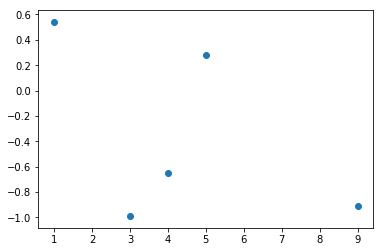

In [33]:
plt.scatter(train_X, train_y)

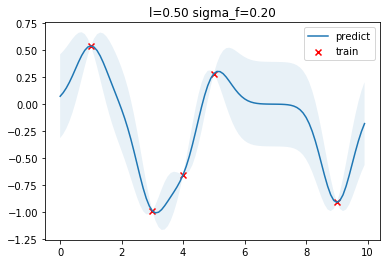

In [34]:
gpr = GPR()
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()